<div>
<h1>Autocorrelation Phase Matrix</h1> 
</div>

### Import libraries

In [1]:
import os
import sys
import librosa
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import IPython.display as ipd

### Define utilities functions

In [2]:
def compute_novelty(x, Fs=1, N=512, H=256, gamma=None, norm=1):
    """Energy-based novelty function 
    """    
    x_power = x**2
    w = sp.signal.windows.hann(N)
    Fs_feature = Fs/H
    energy_local = np.convolve(x**2, w**2 , 'same')
    #downsample every H samples
    energy_local = energy_local[::H]
    
    if gamma!=None:
        energy_local = np.log(1 + gamma * energy_local)
        
    energy_local_diff = np.diff(energy_local)
    energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
    novelty_energy = np.copy(energy_local_diff)
    novelty_energy[energy_local_diff < 0] = 0
    
    if norm==1:
        max_value = max(novelty_energy)
        if max_value > 0:
            novelty_energy = novelty_energy / max_value
    return novelty_energy, Fs_feature

In [3]:
def compute_APM(x, lags):
    N = len(x)
    n_lags = len(lags)
    max_lag = lags[-1]                   
    P = np.zeros((n_lags, max_lag))
    C = np.zeros((n_lags, max_lag))
    # for all the lags k
    for lag_index in np.arange(n_lags):
        k = lags[lag_index]                   
        for phi in np.arange(k):
            n = np.ceil(( N-phi)/k)                       
            i = np.array(phi + k*np.arange(n), dtype=int) 
            P[lag_index,phi] = np.sum(x[i[0:-1]] * x[i[1:]])    
            C[lag_index,phi] = n-1                               
    C[C==0]=1 

    return P, C

In [4]:
def smooth(x, win_length=3, win_type='boxcar'):
    if x.ndim != 1:
        raise ValueError('smooth only accepts 1 dimension arrays.')

    if x.size < win_length:
        raise ValueError('Input vector needs to be bigger than window size.')

    if win_length<3:
        return x
    # mirror pad
    s = np.pad(x, int(win_length/2), mode='reflect')    
    # create window
    w = sp.signal.windows.get_window(win_type, win_length)
    # convolve with normalized window
    y=np.convolve(w/w.sum(), s, mode='valid')
    # return the useful part of y
    
    #Normalize
    y = y / max(y)
    
    #Input/output same size
    if x.size != y.size:
        raise ValueError('The resulting array has got a different size')
    
    return y

## Input preparation

### Define audio signals

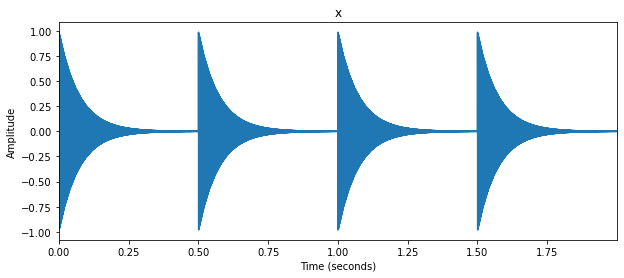

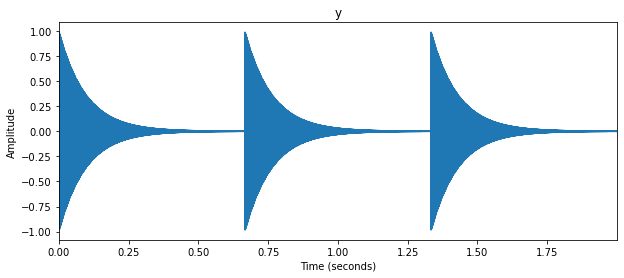

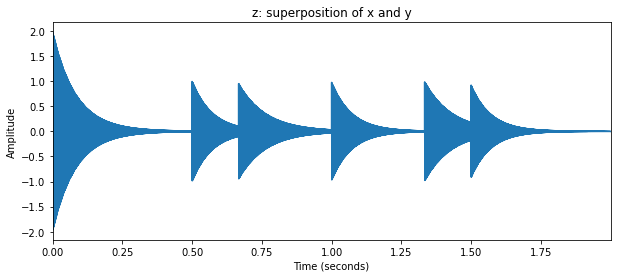

In [5]:
Fs = 22050
measure = 2
times1 = np.array([0, 0.5, 1, 1.5])
times2 = np.array([0, 2/3, 4/3])

x = librosa.clicks(times1, sr=Fs, click_duration=0.5, length=measure*Fs)
y = librosa.clicks(times2, sr=Fs, click_duration=2/3, length=measure*Fs)
z = x + y

time_axis = np.arange(x.shape[0]) / Fs

plt.figure(figsize=(10,4))
plt.xlim([time_axis[0], time_axis[-1]])
plt.title('x')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

plt.plot(time_axis, x)

ipd.display(ipd.Audio(x , rate=Fs))

plt.figure(figsize=(10,4))
plt.xlim([time_axis[0], time_axis[-1]])
plt.title('y')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.plot(time_axis, y)

ipd.display(ipd.Audio(y , rate=Fs))

plt.figure(figsize=(10,4))
plt.xlim([time_axis[0], time_axis[-1]])
plt.title('z: superposition of x and y')
plt.ylabel('Amplitude')
plt.xlabel('Time (seconds)')
plt.plot(time_axis, z)

ipd.display(ipd.Audio(z , rate=Fs))

### Compute novelty curves

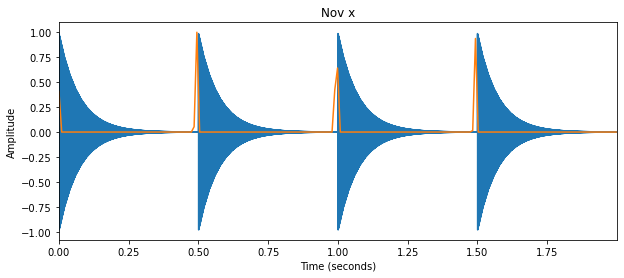

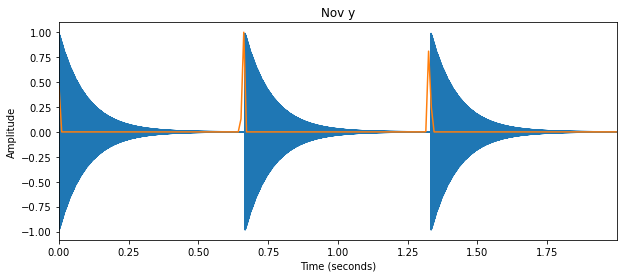

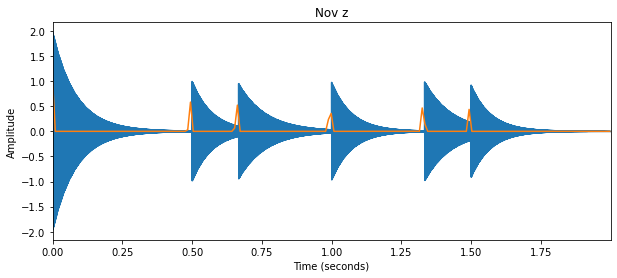

In [6]:
N = 512
H = 218
gamma = None

nov_x, Fs_f_x = compute_novelty(x, Fs=Fs, N=N, H=H)
nov_y, Fs_f_y = compute_novelty(y, Fs=Fs, N=N, H=H)
nov_z, Fs_f_z = compute_novelty(z, Fs=Fs, N=N, H=H)

time_axis_nov = np.arange(nov_x.shape[0]) / Fs_f_x

plt.figure(figsize=(10,4))
plt.xlim([time_axis[0], time_axis[-1]])
plt.title('Nov x')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.plot(time_axis, x)
plt.plot(time_axis_nov, nov_x)

plt.figure(figsize=(10,4))
plt.xlim([time_axis[0], time_axis[-1]])
plt.title('Nov y')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.plot(time_axis, y)
plt.plot(time_axis_nov, nov_y)

plt.figure(figsize=(10,4))
plt.xlim([time_axis[0], time_axis[-1]])
plt.title('Nov z')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.plot(time_axis, z)
plt.plot(time_axis_nov, nov_z)

## Autocorrelation Phase Matrix Parameters

In [7]:
bpm1 = 40
bpm2 = 260
r = 1/Fs_f_x
kmax = round(60/(r*bpm1))
kmin = round(60/(r*bpm2))

lags = np.arange(kmin, kmax)

## Autocorrelation Phase Matrix Computation

### Apply smoothing

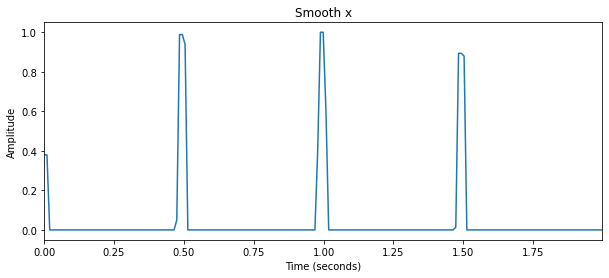

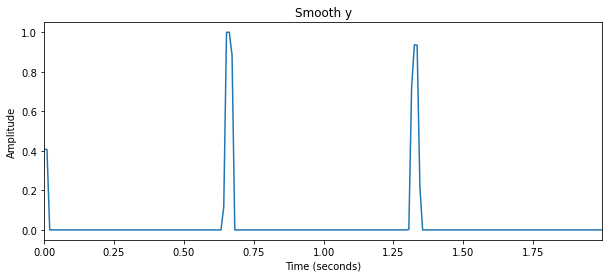

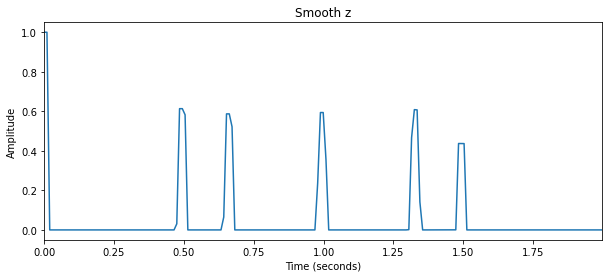

In [8]:
win_length = 3
win_type = 'boxcar'

smooth_nov_x = smooth(nov_x, win_length=win_length, win_type=win_type)
smooth_nov_y = smooth(nov_y, win_length=win_length, win_type=win_type)
smooth_nov_z = smooth(nov_z, win_length=win_length, win_type=win_type)

plt.figure(figsize=(10,4))
plt.xlim([time_axis_nov[0], time_axis_nov[-1]])
plt.title('Smooth x')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.plot(time_axis_nov, smooth_nov_x)

plt.figure(figsize=(10,4))
plt.xlim([time_axis_nov[0], time_axis_nov[-1]])
plt.title('Smooth y')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.plot(time_axis_nov, smooth_nov_y)

plt.figure(figsize=(10,4))
plt.xlim([time_axis_nov[0], time_axis_nov[-1]])
plt.title('Smooth z')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.plot(time_axis_nov, smooth_nov_z)

### Add constant noise

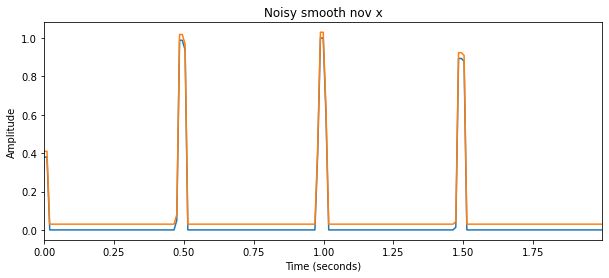

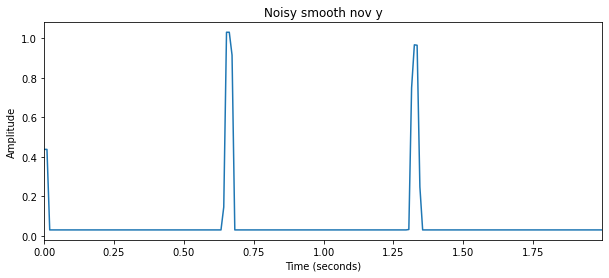

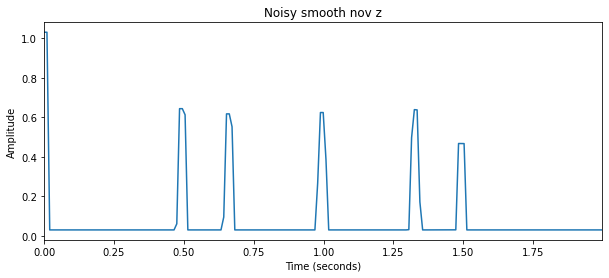

In [9]:
noise = 0.03+0*np.random.randn(len(smooth_nov_x))

noisy_smooth_nov_x = smooth_nov_x + noise
noisy_smooth_nov_y = smooth_nov_y + noise
noisy_smooth_nov_z = smooth_nov_z + noise

plt.figure(figsize=(10,4))
plt.xlim([time_axis_nov[0], time_axis_nov[-1]])
plt.title('Noisy smooth nov x')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.plot(time_axis_nov, smooth_nov_x)
plt.plot(time_axis_nov, noisy_smooth_nov_x)

plt.figure(figsize=(10,4))
plt.xlim([time_axis_nov[0], time_axis_nov[-1]])
plt.title('Noisy smooth nov y')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.plot(time_axis_nov, noisy_smooth_nov_y)

plt.figure(figsize=(10,4))
plt.xlim([time_axis_nov[0], time_axis_nov[-1]])
plt.title('Noisy smooth nov z')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.plot(time_axis_nov, noisy_smooth_nov_z)

### Compute APM

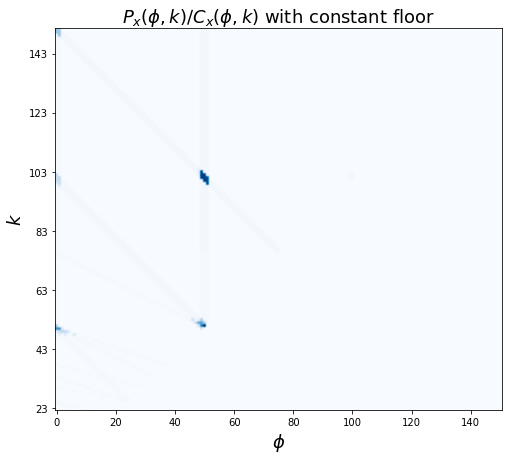

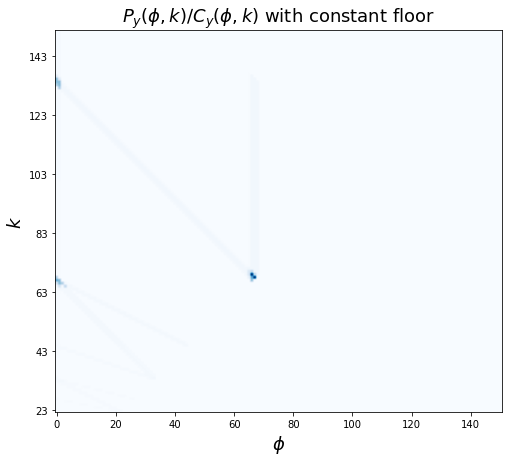

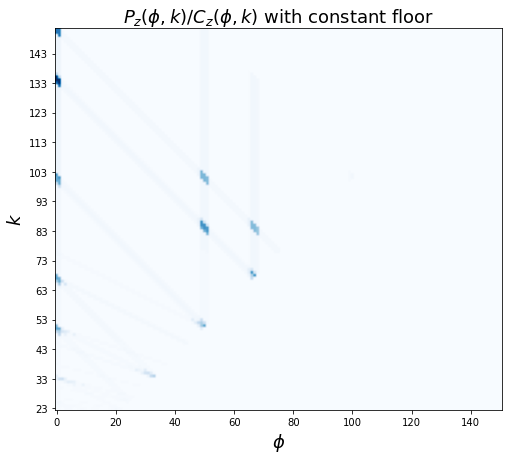

In [10]:
P_x, C_x = compute_APM(noisy_smooth_nov_x, lags)
P_y, C_y = compute_APM(noisy_smooth_nov_y, lags)
P_z, C_z = compute_APM(noisy_smooth_nov_z, lags)

A_x = P_x / C_x
A_y = P_y / C_y
A_z = P_z / C_z

plt.figure(figsize=(8,8))
plt.imshow(A_x, cmap=plt.get_cmap('Blues'), origin='lower')
plt.xlabel(r'$\phi$', fontsize=18)
plt.ylabel(r'$k$', fontsize=18)
plt.yticks(np.arange(0, kmax - kmin, 20), lags[::20])
plt.title(r'$P_x(\phi, k)\slash C_x(\phi, k)$ with constant floor', fontsize=18)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(A_y, cmap=plt.get_cmap('Blues'), origin='lower')
plt.xlabel(r'$\phi$', fontsize=18)
plt.ylabel(r'$k$', fontsize=18)
plt.yticks(np.arange(0, kmax - kmin, 20), lags[::20])
plt.title(r'$P_y(\phi, k) \slash C_y(\phi, k)$ with constant floor', fontsize=18)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(A_z, cmap=plt.get_cmap('Blues'), origin='lower')
plt.xlabel(r'$\phi$', fontsize=18)
plt.ylabel(r'$k$', fontsize=18)
plt.yticks(np.arange(0, kmax - kmin, 10), lags[::10])
plt.title(r'$P_z(\phi, k) \slash C_z(\phi, k)$ with constant floor', fontsize=18)
plt.show()

## Autocorrelation Phase Matrix Tempo Analysis

119 89


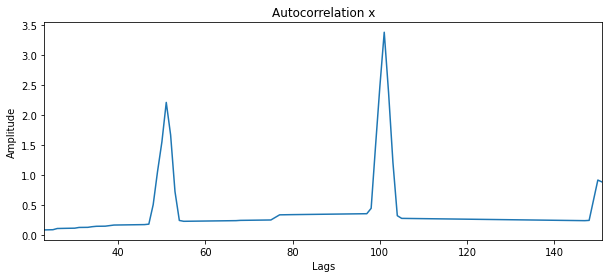

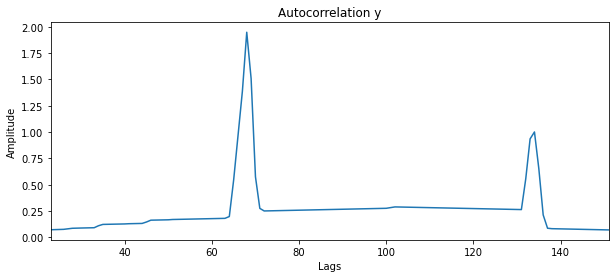

In [11]:
ris = A_x.sum(axis=1)
peaks, properties = sp.signal.find_peaks(ris, prominence=0.02)
peaks_lag = lags[peaks]

plt.figure(figsize=(10,4))
plt.plot(lags, ris)
plt.xlim([lags[0], lags[-1]])
plt.title('Autocorrelation x')
plt.xlabel('Lags')
plt.ylabel('Amplitude')

ris = A_y.sum(axis=1)
peaks2, properties = sp.signal.find_peaks(ris, prominence=0.2)
peaks_lag2 = lags[peaks2]

plt.figure(figsize=(10,4))
plt.plot(lags, ris)
plt.xlim([lags[0], lags[-1]])
plt.title('Autocorrelation y')
plt.xlabel('Lags')
plt.ylabel('Amplitude')


BPM_x = round(60/(r*peaks_lag[0]))
BPM_y = round(60/(r*peaks_lag2[0]))

print(BPM_x, BPM_y)

# Autocorrelation Phase Matrix Rhythmic Analysis

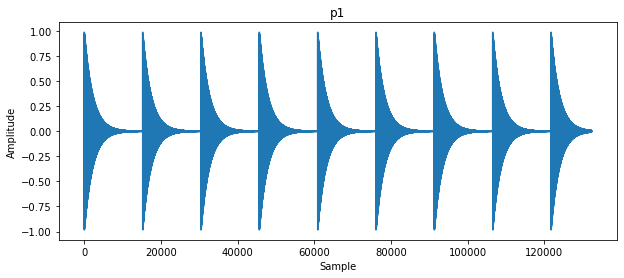

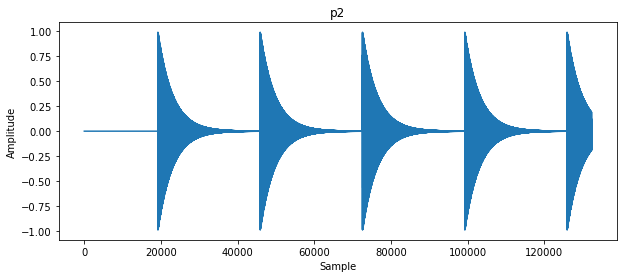

In [13]:
import numpy as np
apm_dict = np.load('apm_dict.npy', allow_pickle=True).item()

kmin = min(apm_dict['k'])
kmax = max(apm_dict['k'])

lags = np.arange(kmin, kmax)

ris = apm_dict['apm'].sum(axis=1)
peaks, properties = sp.signal.find_peaks(ris, prominence=3)
peaks_lag = lags[peaks]/100

phase_min = min(apm_dict['phi']);
phase_max = max(apm_dict['phi']);

phases = np.arange(phase_min, phase_max);

ris = apm_dict['apm'].sum(axis=0)
peaks, properties = sp.signal.find_peaks(ris, prominence=2)
peaks_phase = phases[peaks]/100


p1 =[];
p2 =[];

for i in range(int(np.floor(6/peaks_lag[0]))+1):
    p1.append(i*peaks_lag[0]);
    
for i in range(int(np.floor(6/peaks_lag[1]))+1):
    p2.append(i*peaks_lag[1] + peaks_phase[-1]);
    
pulses = sorted(p1 + p2)

click1 = librosa.clicks(p1, click_duration=0.69, sr=Fs, length = 6*Fs)
click2 = librosa.clicks(p2, click_duration=1.21, sr=Fs, length = 6*Fs)

plt.figure(figsize=(10,4))
plt.title('p1')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.plot(click1)

ipd.display(ipd.Audio(click1 , rate=Fs))

plt.figure(figsize=(10,4))
plt.title('p2')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.plot(click2)

ipd.display(ipd.Audio(click2 , rate=Fs))


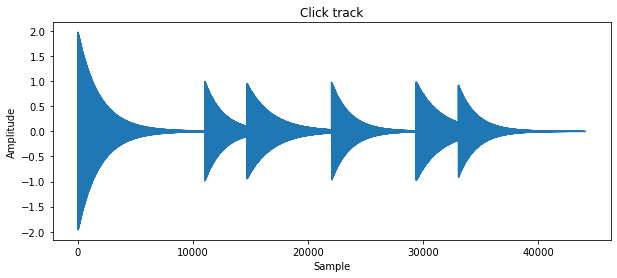

In [14]:
click_track = librosa.clicks(pulses, sr=Fs, length = 6*Fs)

plt.figure(figsize=(10,4))
plt.title('Click track')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.plot(z)

ipd.display(ipd.Audio(z, rate=Fs))